In [1]:
!pip install -q torch torchvision timm einops

In [2]:
import os
import math
from pathlib import Path
from datetime import datetime
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from einops import rearrange

def set_seed(seed=42):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

set_seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)

Device: cuda


In [3]:
config = {
'image_size': 32, # CIFAR-10 images
'patch_size': 4, # 4x4 patches -> (32/4)^2 = 64 tokens
'in_chans': 3,
'num_classes': 10,
'dim': 256, # embedding dim (width)
'depth': 8, # number of Transformer encoder blocks
'mlp_ratio': 4,
'num_heads': 8,
'dropout': 0.0,
'emb_dropout': 0.0,
'batch_size': 256,
'epochs': 60,
'lr': 3e-4,
'weight_decay': 0.05,
'label_smoothing': 0.1,
}

In [4]:
train_transform = transforms.Compose([
transforms.RandomCrop(32, padding=4),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465),(0.247,0.243,0.261)),
])


test_transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465),(0.247,0.243,0.261)),
])


train_ds = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
val_ds = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)


train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 170M/170M [01:29<00:00, 1.91MB/s]


In [5]:
class PatchEmbedding(nn.Module):
  def __init__(self, image_size, patch_size, in_chans, embed_dim):
    super().__init__()
    assert image_size % patch_size == 0, 'image must be divisible by patch size'
    self.num_patches = (image_size // patch_size) ** 2
    self.patch_size = patch_size
    # use conv to create patch embeddings
    self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    # x: (B, C, H, W)
    x = self.proj(x) # (B, embed_dim, H/ps, W/ps)
    x = x.flatten(2).transpose(1,2) # (B, num_patches, embed_dim)
    return x


class MLP(nn.Module):
  def __init__(self, in_features, hidden_features=None, drop=0.):
    super().__init__()
    hidden_features = hidden_features or in_features
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.act = nn.GELU()
    self.fc2 = nn.Linear(hidden_features, in_features)
    self.drop = nn.Dropout(drop)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.drop(x)
    return x

class TransformerEncoderBlock(nn.Module):
  def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.):
    super().__init__()
    self.norm1 = nn.LayerNorm(dim)
    self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=attn_drop, batch_first=True)
    self.drop_path = nn.Identity()
    self.norm2 = nn.LayerNorm(dim)
    self.mlp = MLP(dim, int(dim*mlp_ratio), drop=drop)

  def forward(self, x):
    # x: (B, N, C)
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

class ViT(nn.Module):
  def __init__(self, image_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=256, depth=8, num_heads=8, mlp_ratio=4., emb_dropout=0., dropout=0.):
    super().__init__()
    self.patch_embed = PatchEmbedding(image_size, patch_size, in_chans, embed_dim)
    num_patches = self.patch_embed.num_patches


    # CLS token
    self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
    # positional embeddings
    self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))
    self.pos_drop = nn.Dropout(p=emb_dropout)


    # Transformer Encoder blocks
    self.blocks = nn.ModuleList([
      TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, drop=dropout, attn_drop=dropout)
      for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)


    # initialize
    nn.init.trunc_normal_(self.pos_embed, std=0.02)
    nn.init.trunc_normal_(self.cls_token, std=0.02)
    self.apply(self._init_weights)

  def _init_weights(self, m):
    if isinstance(m, nn.Linear):
      nn.init.trunc_normal_(m.weight, std=0.02)
      if m.bias is not None:
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
      nn.init.zeros_(m.bias)
      nn.init.ones_(m.weight)


  def forward(self, x):
    B = x.shape[0]
    x = self.patch_embed(x) # (B, N, C)
    cls_tokens = self.cls_token.expand(B, -1, -1) # (B,1,C)
    x = torch.cat((cls_tokens, x), dim=1) # (B, N+1, C)
    x = x + self.pos_embed
    x = self.pos_drop(x)
    for blk in self.blocks:
      x = blk(x)
    x = self.norm(x)
    cls = x[:,0]
    logits = self.head(cls)
    return logits

In [7]:
model = ViT(
  image_size=config['image_size'],
  patch_size=config['patch_size'],
  in_chans=config['in_chans'],
  num_classes=config['num_classes'],
  embed_dim=config['dim'],
  depth=config['depth'],
  num_heads=config['num_heads'],
  mlp_ratio=config['mlp_ratio'],
  emb_dropout=config['emb_dropout'],
  dropout=config['dropout'],
).to(DEVICE)

print(model)


class LabelSmoothingCrossEntropy(nn.Module):
  def __init__(self, smoothing=0.0):
    super().__init__()
    self.smoothing = smoothing

  def forward(self, pred, target):
    logprobs = F.log_softmax(pred, dim=-1)
    nll = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
    smooth_loss = -logprobs.mean(dim=-1)
    loss = (1.0 - self.smoothing) * nll + self.smoothing * smooth_loss
    return loss.mean()

criterion = LabelSmoothingCrossEntropy(config['label_smoothing'])

optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])

ViT(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TransformerEncoderBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
from tqdm import tqdm

def train_one_epoch(epoch):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  pbar = tqdm(train_loader, desc=f'Train Ep {epoch}')
  for imgs, targets in pbar:
    imgs = imgs.to(DEVICE)
    targets = targets.to(DEVICE)
    optimizer.zero_grad()
    logits = model(imgs)
    loss = criterion(logits, targets)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * imgs.size(0)
    preds = logits.argmax(dim=1)
    correct += (preds == targets).sum().item()
    total += imgs.size(0)
    pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
  return running_loss/total, correct/total

def evaluate():
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for imgs, targets in val_loader:
      imgs = imgs.to(DEVICE)
      targets = targets.to(DEVICE)
      logits = model(imgs)
      loss = criterion(logits, targets)
      running_loss += loss.item() * imgs.size(0)
      preds = logits.argmax(dim=1)
      correct += (preds == targets).sum().item()
      total += imgs.size(0)
  return running_loss/total, correct/total

In [10]:
best_acc = 0.0
logs = []
start_time = datetime.now()
for epoch in range(1, config['epochs']+1):
  train_loss, train_acc = train_one_epoch(epoch)
  val_loss, val_acc = evaluate()
  scheduler.step()
  logs.append((epoch, train_loss, train_acc, val_loss, val_acc))
  print(f"Epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
  if val_acc > best_acc:
    best_acc = val_acc
    torch.save({
      'model_state': model.state_dict(),
      'config': config,
      'epoch': epoch,
      'best_acc': best_acc,
    }, 'best_vit_cifar10.pth')


print('Training finished. Best val acc:', best_acc)
print('Elapsed:', datetime.now() - start_time)

Train Ep 1: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s, loss=1.88, acc=0.336]


Epoch 1: train_loss=1.8841 train_acc=0.3363 val_loss=1.7319 val_acc=0.4219


Train Ep 2: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s, loss=1.62, acc=0.476]


Epoch 2: train_loss=1.6217 train_acc=0.4757 val_loss=1.5473 val_acc=0.5230


Train Ep 3: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.5, acc=0.536]


Epoch 3: train_loss=1.4993 train_acc=0.5356 val_loss=1.4785 val_acc=0.5515


Train Ep 4: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=1.42, acc=0.575]


Epoch 4: train_loss=1.4233 train_acc=0.5750 val_loss=1.4424 val_acc=0.5752


Train Ep 5: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=1.37, acc=0.599]


Epoch 5: train_loss=1.3679 train_acc=0.5995 val_loss=1.3573 val_acc=0.6088


Train Ep 6: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.32, acc=0.622]


Epoch 6: train_loss=1.3179 train_acc=0.6216 val_loss=1.3372 val_acc=0.6117


Train Ep 7: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=1.27, acc=0.644]


Epoch 7: train_loss=1.2748 train_acc=0.6438 val_loss=1.2803 val_acc=0.6412


Train Ep 8: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=1.24, acc=0.662]


Epoch 8: train_loss=1.2363 train_acc=0.6618 val_loss=1.2160 val_acc=0.6755


Train Ep 9: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.21, acc=0.678]


Epoch 9: train_loss=1.2066 train_acc=0.6779 val_loss=1.2059 val_acc=0.6832


Train Ep 10: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=1.18, acc=0.69]


Epoch 10: train_loss=1.1806 train_acc=0.6903 val_loss=1.2054 val_acc=0.6793


Train Ep 11: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.14, acc=0.711]


Epoch 11: train_loss=1.1406 train_acc=0.7111 val_loss=1.1852 val_acc=0.6934


Train Ep 12: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.11, acc=0.721]


Epoch 12: train_loss=1.1140 train_acc=0.7215 val_loss=1.1335 val_acc=0.7159


Train Ep 13: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.08, acc=0.736]


Epoch 13: train_loss=1.0835 train_acc=0.7357 val_loss=1.1061 val_acc=0.7251


Train Ep 14: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.06, acc=0.747]


Epoch 14: train_loss=1.0636 train_acc=0.7466 val_loss=1.0918 val_acc=0.7323


Train Ep 15: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.04, acc=0.752]


Epoch 15: train_loss=1.0442 train_acc=0.7522 val_loss=1.0969 val_acc=0.7238


Train Ep 16: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=1.02, acc=0.764]


Epoch 16: train_loss=1.0233 train_acc=0.7641 val_loss=1.0552 val_acc=0.7527


Train Ep 17: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.995, acc=0.777]


Epoch 17: train_loss=0.9946 train_acc=0.7768 val_loss=1.0675 val_acc=0.7450


Train Ep 18: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.979, acc=0.783]


Epoch 18: train_loss=0.9787 train_acc=0.7825 val_loss=1.0458 val_acc=0.7545


Train Ep 19: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.956, acc=0.796]


Epoch 19: train_loss=0.9556 train_acc=0.7959 val_loss=1.0380 val_acc=0.7634


Train Ep 20: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.939, acc=0.803]


Epoch 20: train_loss=0.9390 train_acc=0.8030 val_loss=1.0480 val_acc=0.7557


Train Ep 21: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.92, acc=0.813]


Epoch 21: train_loss=0.9200 train_acc=0.8129 val_loss=1.0422 val_acc=0.7537


Train Ep 22: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.903, acc=0.818]


Epoch 22: train_loss=0.9028 train_acc=0.8179 val_loss=1.0221 val_acc=0.7678


Train Ep 23: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.887, acc=0.824]


Epoch 23: train_loss=0.8872 train_acc=0.8240 val_loss=1.0079 val_acc=0.7741


Train Ep 24: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.863, acc=0.837]


Epoch 24: train_loss=0.8627 train_acc=0.8374 val_loss=0.9974 val_acc=0.7817


Train Ep 25: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.847, acc=0.844]


Epoch 25: train_loss=0.8468 train_acc=0.8436 val_loss=0.9993 val_acc=0.7787


Train Ep 26: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.829, acc=0.853]


Epoch 26: train_loss=0.8286 train_acc=0.8528 val_loss=0.9944 val_acc=0.7834


Train Ep 27: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.814, acc=0.86]


Epoch 27: train_loss=0.8136 train_acc=0.8600 val_loss=0.9876 val_acc=0.7858


Train Ep 28: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.795, acc=0.867]


Epoch 28: train_loss=0.7948 train_acc=0.8672 val_loss=0.9804 val_acc=0.7894


Train Ep 29: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.773, acc=0.88]


Epoch 29: train_loss=0.7728 train_acc=0.8801 val_loss=0.9801 val_acc=0.7951


Train Ep 30: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.763, acc=0.882]


Epoch 30: train_loss=0.7630 train_acc=0.8820 val_loss=0.9855 val_acc=0.7918


Train Ep 31: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.75, acc=0.889]


Epoch 31: train_loss=0.7504 train_acc=0.8893 val_loss=0.9777 val_acc=0.7965


Train Ep 32: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.727, acc=0.899]


Epoch 32: train_loss=0.7271 train_acc=0.8988 val_loss=0.9989 val_acc=0.7904


Train Ep 33: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.713, acc=0.905]


Epoch 33: train_loss=0.7134 train_acc=0.9051 val_loss=1.0054 val_acc=0.7944


Train Ep 34: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.699, acc=0.912]


Epoch 34: train_loss=0.6989 train_acc=0.9118 val_loss=0.9851 val_acc=0.7972


Train Ep 35: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.684, acc=0.918]


Epoch 35: train_loss=0.6843 train_acc=0.9184 val_loss=1.0030 val_acc=0.7948


Train Ep 36: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.666, acc=0.927]


Epoch 36: train_loss=0.6660 train_acc=0.9267 val_loss=1.0059 val_acc=0.7956


Train Ep 37: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.656, acc=0.932]


Epoch 37: train_loss=0.6558 train_acc=0.9320 val_loss=1.0124 val_acc=0.7981


Train Ep 38: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.639, acc=0.939]


Epoch 38: train_loss=0.6386 train_acc=0.9393 val_loss=1.0122 val_acc=0.7985


Train Ep 39: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.631, acc=0.943]


Epoch 39: train_loss=0.6308 train_acc=0.9426 val_loss=1.0096 val_acc=0.8018


Train Ep 40: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.62, acc=0.948]


Epoch 40: train_loss=0.6200 train_acc=0.9480 val_loss=1.0165 val_acc=0.8006


Train Ep 41: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.607, acc=0.953]


Epoch 41: train_loss=0.6073 train_acc=0.9530 val_loss=1.0203 val_acc=0.8017


Train Ep 42: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.597, acc=0.959]


Epoch 42: train_loss=0.5971 train_acc=0.9590 val_loss=1.0181 val_acc=0.8033


Train Ep 43: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.59, acc=0.962]


Epoch 43: train_loss=0.5896 train_acc=0.9620 val_loss=1.0252 val_acc=0.8029


Train Ep 44: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.581, acc=0.967]


Epoch 44: train_loss=0.5809 train_acc=0.9667 val_loss=1.0259 val_acc=0.8025


Train Ep 45: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.575, acc=0.968]


Epoch 45: train_loss=0.5751 train_acc=0.9684 val_loss=1.0341 val_acc=0.8023


Train Ep 46: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.568, acc=0.971]


Epoch 46: train_loss=0.5681 train_acc=0.9713 val_loss=1.0380 val_acc=0.8020


Train Ep 47: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.56, acc=0.976]


Epoch 47: train_loss=0.5603 train_acc=0.9757 val_loss=1.0427 val_acc=0.8030


Train Ep 48: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.556, acc=0.977]


Epoch 48: train_loss=0.5558 train_acc=0.9767 val_loss=1.0351 val_acc=0.8042


Train Ep 49: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.552, acc=0.979]


Epoch 49: train_loss=0.5515 train_acc=0.9789 val_loss=1.0354 val_acc=0.8051


Train Ep 50: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.546, acc=0.982]


Epoch 50: train_loss=0.5462 train_acc=0.9816 val_loss=1.0490 val_acc=0.8049


Train Ep 51: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.544, acc=0.983]


Epoch 51: train_loss=0.5435 train_acc=0.9828 val_loss=1.0472 val_acc=0.8040


Train Ep 52: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.542, acc=0.983]


Epoch 52: train_loss=0.5422 train_acc=0.9832 val_loss=1.0457 val_acc=0.8069


Train Ep 53: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.539, acc=0.985]


Epoch 53: train_loss=0.5395 train_acc=0.9846 val_loss=1.0472 val_acc=0.8048


Train Ep 54: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.536, acc=0.987]


Epoch 54: train_loss=0.5365 train_acc=0.9866 val_loss=1.0530 val_acc=0.8053


Train Ep 55: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s, loss=0.534, acc=0.987]


Epoch 55: train_loss=0.5345 train_acc=0.9866 val_loss=1.0488 val_acc=0.8079


Train Ep 56: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s, loss=0.533, acc=0.988]


Epoch 56: train_loss=0.5330 train_acc=0.9883 val_loss=1.0486 val_acc=0.8072


Train Ep 57: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.534, acc=0.987]


Epoch 57: train_loss=0.5336 train_acc=0.9873 val_loss=1.0491 val_acc=0.8078


Train Ep 58: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.53, acc=0.989]


Epoch 58: train_loss=0.5302 train_acc=0.9893 val_loss=1.0487 val_acc=0.8069


Train Ep 59: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.531, acc=0.988]


Epoch 59: train_loss=0.5314 train_acc=0.9885 val_loss=1.0492 val_acc=0.8075


Train Ep 60: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s, loss=0.533, acc=0.988]


Epoch 60: train_loss=0.5326 train_acc=0.9876 val_loss=1.0489 val_acc=0.8073
Training finished. Best val acc: 0.8079
Elapsed: 1:05:05.436691


Loaded best checkpoint — val loss: 1.0487583292007445 val acc: 0.8079


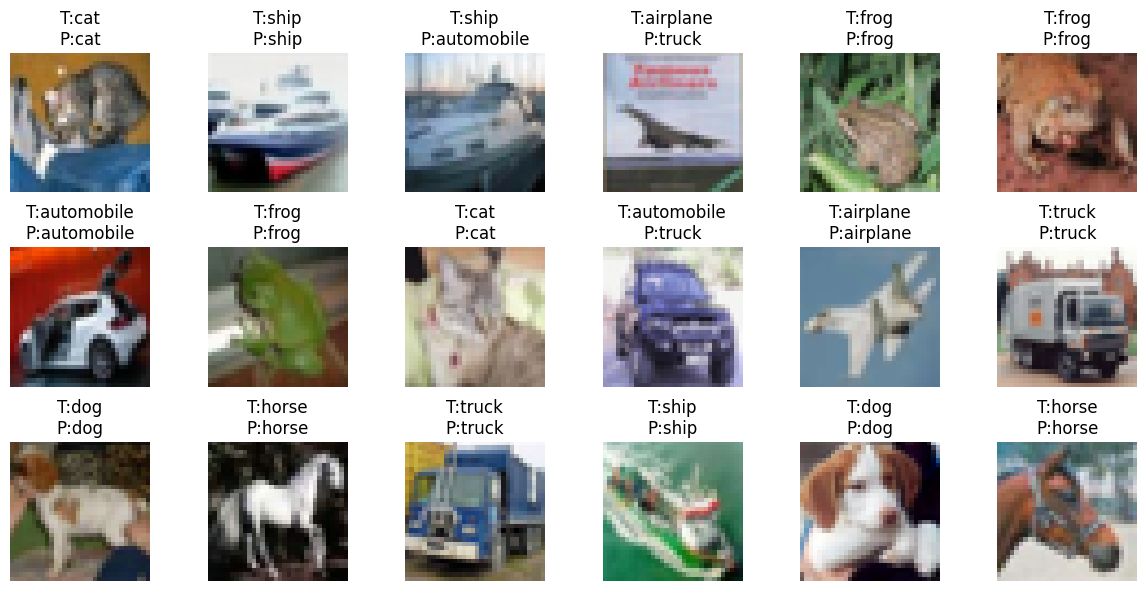

In [11]:
checkpoint = torch.load('best_vit_cifar10.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state'])
loss, acc = evaluate()
print('Loaded best checkpoint — val loss:', loss, 'val acc:', acc)


# Show some predictions
import matplotlib.pyplot as plt
import numpy as np
classes = train_ds.classes
model.eval()
imgs, targets = next(iter(val_loader))
with torch.no_grad():
  logits = model(imgs.to(DEVICE))
  preds = logits.argmax(dim=1).cpu().numpy()


fig, axes = plt.subplots(3,6, figsize=(12,6))
for ax, img, t, p in zip(axes.flatten(), imgs, targets, preds):
  im = img.permute(1,2,0).numpy()
  im = (im * np.array([0.247,0.243,0.261]) + np.array([0.4914,0.4822,0.4465]))
  im = np.clip(im, 0, 1)
  ax.imshow(im)
  ax.set_title(f'T:{classes[t]}\nP:{classes[p]}')
  ax.axis('off')
plt.tight_layout()